# NOTEBOOK Title 
***

Description of your challenge and instructions for challenge participants

⚠️ NOTE: describe everything in detail whethere it is data loading, visualization, training, or scoring. Your competition participants will use all the details to better understand your challenge.

***

`COLAB` determines whether this notebook is running on Google Colab.

In [2]:
COLAB = 'google.colab' in str(get_ipython())

In [3]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/FAIR-Universe/M1-AI-Challenge-Class-2025-26.git
    # move to the starting kit folder
    %cd M1-AI-Challenge-Class-2025-26/Starting_Kit/

# 0 - Imports & Settings

In [ ]:
import os
import json
import zipfile
import joblib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
%matplotlib inline

# 1 - Data
This is a sample code to load data. Update this description and the code to load your data

In [5]:
class Data:
    def __init__(self, data_dir):
        # data_dir : Pollinator-Data-CNN-Extracted/
        self.data_dir = data_dir
        self.features = None
        self.labels = None
        self.indices = None
        self.metadata = None
        self.class_map = None
        
    def load_data(self):
        # 1. Features
        f_path = os.path.join(self.data_dir, "trainValTest_N=2197469_prod2_features_model=efficientnetB3_tsfrm=dataset_labeledOnly.npy")
        self.features = np.load(f_path)
        
        # 2. Labels
        l_path = os.path.join(self.data_dir, "trainValTest_N=2197469_prod2_nObs=4242_labels_labeledOnly.npz")
        label_data = np.load(l_path)
        raw_labels = label_data[label_data.files[0]]
        
        # Re-assign classes: 0 becomes -1 (no visitor), others become 1 (visitor)
        self.labels = np.where(raw_labels == 0, -1, 1)
        
        # 3. Indices
        i_path = os.path.join(self.data_dir, "trainValTest_N=2197469_prod2_features_model=efficientnetB3_tsfrm=dataset_labeledOnly_indices.npy")
        self.indices = np.load(i_path)
        
        # 4. Metadata
        m_path = os.path.join(self.data_dir, "trainValTest_N=2197469_prod2_metadata_labeledOnly.npz")
        self.metadata = np.load(m_path)
        
        # 5. Class Map
        # Note: We update the map to reflect the new binary task
        self.class_map = {"-1": "no visitor", "1": "visitor"}

        print(f"Features shape: {self.features.shape}")
        print(f"Labels shape: {self.labels.shape}")
        print(f"Binary classes: {np.unique(self.labels)}")

In [6]:
# Change data_dir to the path where you have extracted the Pollinator-Data-CNN-Extracted.zip
data = Data(data_dir="../Pollinator/Pollinator-Data-CNN-Extracted/")
data.load_data()

Features shape: (704361, 1536)
Labels shape: (704361,)
Binary classes: [-1  1]


# 2 - Visualization
This is a sample code to visualize data. Update this description and the code to fit your usecase.

In [7]:
class Visualize:
    def __init__(self, data):
        self.data = data

    def plot_class_distribution(self):
        labels = self.data.labels
        names = [self.data.class_map.get(str(l), str(l)) for l in labels]
        
        plt.figure(figsize=(10, 5))
        sns.countplot(x=names, palette="magma")
        plt.title("Binary Class Distribution (Pollinators)")
        plt.xlabel("Category")
        plt.ylabel("Number of samples")
        plt.show()

    def plot_pca(self, n_per_class=500):
        """Reduces CNN features to 2D with balanced classes (500 each)."""
        print(f"Balancing data: selecting {n_per_class} samples for each class...")
        
        # Get indices for each class
        indices_neg = np.where(self.data.labels == -1)[0]
        indices_pos = np.where(self.data.labels == 1)[0]
        
        # Randomly sample from each
        selected_neg = np.random.choice(indices_neg, n_per_class, replace=False)
        selected_pos = np.random.choice(indices_pos, n_per_class, replace=False)
        
        # Combine and shuffle
        idx = np.concatenate([selected_neg, selected_pos])
        np.random.shuffle(idx)
        
        X_subset = self.data.features[idx]
        y_subset = self.data.labels[idx]
        
        print(f"Computing PCA on {len(idx)} samples...")
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_subset)
        
        # Plotting with distinct colors and a legend
        plt.figure(figsize=(10, 7))
        
        # Plot each class separately to handle the legend correctly
        for label_val, color, label_name in [(-1, 'steelblue', 'No Visitor'), (1, 'orange', 'Visitor')]:
            mask = y_subset == label_val
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                        c=color, label=label_name, alpha=0.6, edgecolors='w')
        
        plt.legend()
        plt.title(f"PCA Projection: {n_per_class} No Visitors vs {n_per_class} Visitors")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.show()

    def plot_data(self):
        """Main visualization function."""
        self.plot_class_distribution()
        self.plot_pca()

/var/folders/nl/6kthgqqn38ld9666g125hfrh0000gn/T/ipykernel_23306/2902902597.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=names, palette="magma")


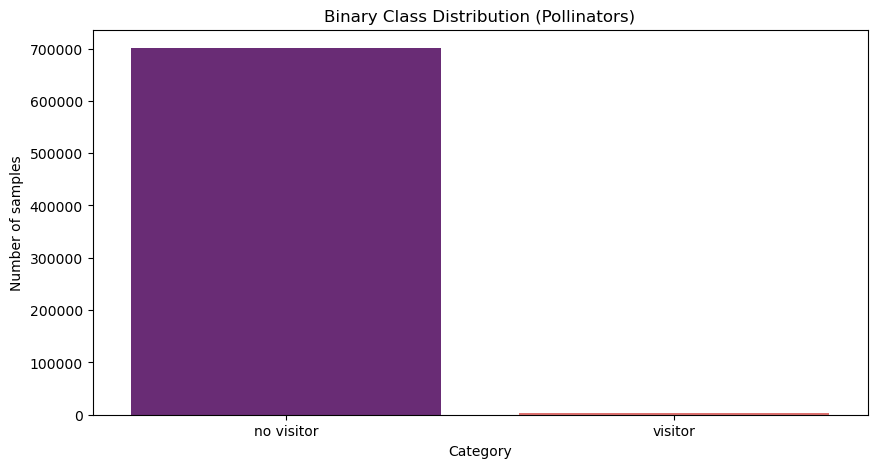

Balancing data: selecting 500 samples for each class...
Computing PCA on 1000 samples...


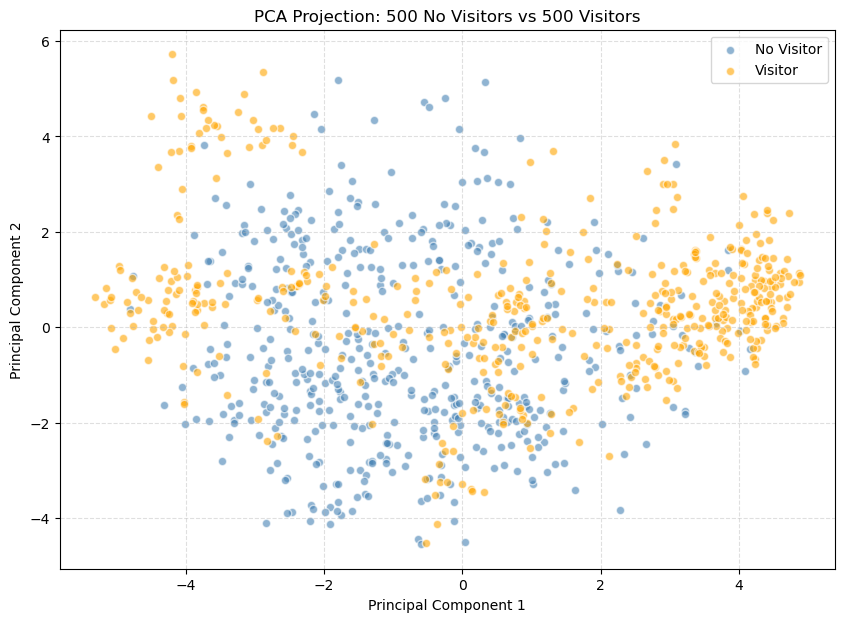

In [8]:
# Example usage
visualize = Visualize(data=data)
visualize.plot_data()

# 3 - Training
This is a sample code to train a model using your data. Update this description and the code to fit your usecase. 

In [9]:
class Train:
    def __init__(self, data: Data):
        # We store the data object and initialize a model
        self.data = data
        self.model = LogisticRegression(max_iter=1000)
        self.X_train, self.X_val, self.y_train, self.y_val = [None] * 4

    def prepare_data(self, test_size=0.2, random_state=42):
        """
        Splits the features and binary labels into training and validation sets.
        'stratify' ensures we have the same proportion of visitors in both sets.
        """
        print("Preparing train/val sets...")
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.data.features, 
            self.data.labels, 
            test_size=test_size, 
            random_state=random_state,
            stratify=self.data.labels
        )
        print(f"Data prepared: {len(self.X_train)} samples for training.")

    def train(self):
        """
        Trains the Logistic Regression model using the extracted CNN features.
        """
        # Ensure data is split before training
        if self.X_train is None:
            self.prepare_data()
            
        print("Starting training (fitting the model)...")
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")

In [ ]:
# Example usage
train = Train(data=data)
train.train()

Preparing train/val sets...
Data prepared: 563488 samples for training.
Starting training (fitting the model)...


# 4 - Scoring
This is a sample code to score your trained model. Update this description and the code to fit your usecase. 

In [ ]:
class Score:
    def __init__(self):
        self.results = {}

    def compute_score(self, y_true, y_pred):
        """
        Computes various metrics to evaluate the model performance.
        y_true: Ground truth labels (-1 or 1)
        y_pred: Model predictions (-1 or 1)
        """
        # 1. Basic Accuracy
        acc = accuracy_score(y_true, y_pred)
        
        # 2. F1-Score (Better for imbalanced data)
        # We specify pos_label=1 to focus on the 'Visitor' detection
        f1 = f1_score(y_true, y_pred, pos_label=1)
        
        # 3. Confusion Matrix (TN, FP, FN, TP)
        cm = confusion_matrix(y_true, y_pred)
        
        # Storing results
        self.results = {
            "accuracy": acc,
            "f1_score": f1,
            "confusion_matrix": cm
        }
        
        print(f"--- Evaluation Results ---")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-Score (Visitor): {f1:.4f}")
        print("\nFull Classification Report:")
        print(classification_report(y_true, y_pred, target_names=['No Visitor', 'Visitor']))
        
        return self.results

In [ ]:
# Example usage
score = Score()
score.compute_score()

# 5 - (Optional) Prepare submission for Codabench

***

In this section you should prepare a zip of the trained model (if your competition is a code submission competition) or zip of the predictions (if your competition is a result submission competition). 

***

In [ ]:
import os
import zipfile
import joblib
import pandas as pd

class Submission:
    def __init__(self, submission_dir, zip_file_name):
        self.submission_dir = submission_dir
        self.zip_file_name = zip_file_name
        # Create directory if it doesn't exist
        os.makedirs(self.submission_dir, exist_ok=True)

    def save_code(self, model):
        """
        Saves the trained model object to the submission directory.
        """
        model_path = os.path.join(self.submission_dir, "model.joblib")
        joblib.dump(model, model_path)
        print(f"Model saved at: {model_path}")

    def save_result(self, predictions):
        """
        Saves the prediction array as a CSV file.
        """
        result_path = os.path.join(self.submission_dir, "results.csv")
        # Convert to DataFrame for a clean CSV
        df = pd.DataFrame(predictions, columns=["prediction"])
        df.to_csv(result_path, index=False)
        print(f"Predictions saved at: {result_path}")
        
    def zip_submission(self):
        # Path to ZIP
        zip_path = os.path.join(self.submission_dir, self.zip_file_name)

        # Create ZIP containing the submission directory files
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            for filename in os.listdir(self.submission_dir):
                file_path = os.path.join(self.submission_dir, filename)

                # Skip the zip file itself and hidden files
                if file_path == zip_path or filename.startswith('.'):
                    continue

                zf.write(file_path, arcname=filename)
        print(f"Submission ZIP saved at: {zip_path}")

In [ ]:
# Example usage
zip_file_name = f"Submission_{datetime.datetime.now().strftime("%y-%m-%d-%H-%M")}.zip"

submission = Submission (
    submission_dir="./submission",
    zip_file_name=zip_file_name
)
submission.save_code()
# or
submission.save_result()

# Zip submission dir
submission.zip_submission()

Submission ZIP saved at: submissions/Submission_25-08-26-21-47.zip
